# Graph Neural Network Implementation

In [639]:
%matplotlib inline
from __future__ import annotations
import random
from typing import Iterable, Mapping, Any
from numpy.random import RandomState
from numpy.typing import ArrayLike
import torch
import torch.nn as nn
from torch.optim import Optimizer, SGD
import matplotlib.pyplot as plt
import networkx as nx

# Fixed random seed

In [640]:
random.seed(0)
random_state: RandomState = RandomState(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Constant

In [641]:
device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_int: torch.dtype = torch.int16
torch_float: torch.dtype = torch.float32

# Utils

In [642]:
def decode_label(y: torch.Tensor) -> list[Any]:
    y_label: torch.Tensor = torch.zeros((y.shape[0]))
    for index in range(y.shape[0]):
        value: int = 0
        if y[index][0] < y[index][1]:
            value = 1
        y_label[index] = value
    return y_label.to(dtype=torch_int).tolist()

# Definition of Graph

In [643]:
class Graph(nx.Graph):
    random_state: RandomState
    pos: Mapping
    def __init__(self, graph: nx.Graph | Graph | None = None, random_state: RandomState | None = None, **kwargs) -> None:
        super(Graph, self).__init__(graph, **kwargs)
        self.random_state = random_state
        self.pos = nx.random_layout(self, seed=self.random_state)

    def subgraph(self, nodes: ArrayLike | Iterable) -> Graph:
        subgraph: Graph = super(Graph, self).subgraph(nodes)
        subgraph.random_state = self.random_state
        subgraph.pos = nx.random_layout(subgraph, seed=subgraph.random_state)
        return subgraph

    def update_pos(self, pos: Mapping) -> None:
        self.pos = pos

    def node_label(self, n: int, key: str = 'label') -> Any:
        return self.nodes[n][key]

    def node_labels(self, key: str = 'label') -> list[Any]:
        return [label[1] for label in self.nodes.data(key)]

    def node_color(self, labels: list[str], colors: list[str]) -> list[str]:
        node_color: list[str] = list[str]()
        for node in self.nodes:
            for index, label in enumerate(labels):
                if self.node_label(node) == label:
                    node_color.append(colors[index])
        return node_color

    def show(self, figsize: tuple[float, float] | None = None, title: str | None = None, labels: tuple[Any] | None = None, colors: tuple[str] | None = None) -> None:
        plt.figure(figsize=figsize)
        if labels is not None and colors is not None:
            nx.draw_networkx(self, self.pos, node_color=self.node_color(labels, colors))
        else:
            nx.draw_networkx(self, self.pos)
        if title is not None:
            plt.title(title)
        plt.show()

# Definition of Graph Neural Network (GNN)

In [644]:

"""
F_w(x,l,G)
x: states (state_dim*n_node)
l: labels (n_node*1)
G: graph
"""
class F_w(nn.Module):
    l_N: int
    s: int 
    l_E: int
    epsilon: float
    def __init__(self, l_N: int, s: int, l_E:int, epsilon: float = 1.0e-4, *args, **kwargs):
        super(F_w, self).__init__(*args, **kwargs)
        self.l_N = l_N
        self.s = s
        self.l_E = l_E
        self.epsilon = epsilon
        self.f = _F_w(l_N, s, l_E)

    def forward(self, xs: dict[int: torch.Tensor], G: Graph) -> dict[int: torch.Tensor]:
        # while True:
        #     xs_next = {}
        #     for n in G.nodes:
        #         xs_next[n] = self.f(xs, G, n)
        #     x_diff_list = [torch.sum(torch.abs(xs[i].clone().detach() - xs_next[i].clone().detach())) for i in xs.keys()]
        #     error = sum(x_diff_list)

        #     if error <= self.epsilon:
        #         break
        #     xs = xs_next
        
        # return xs

        xs_previous: dict[int: torch.Tensor] = xs
        while True:
            xs_next = {}
            for n in G.nodes:
                xs_next[n] = self.f(xs_previous, G, n)
            x_diff_list = [torch.sum(torch.abs(xs_previous[i].clone().detach() - xs_next[i].clone().detach())) for i in xs.keys()]
            error = sum(x_diff_list)

            if error <= self.epsilon:
                break
            xs_previous = xs_next
        
        return xs_next

class _F_w(nn.Module):
    l_N: int
    s: int 
    l_E: int
    h: H_w
    def __init__(self, l_N: int, s: int, l_E:int, *args, **kwargs) -> None:
        super(_F_w, self).__init__(*args, **kwargs)
        self.l_N = l_N
        self.s = s
        self.l_E = l_E
        self.h = H_w(l_N, s, l_E)

    def forward(self, xs: dict[torch.Tensor], G: Graph, n: int) -> None:
        out = torch.zeros((1, self.s))
        for u in G.adj[n]:
            l_n: torch.Tensor = torch.tensor([G.node_label(n)], dtype=torch_float, device=device).unsqueeze(1)
            l_u: torch.Tensor = torch.tensor([G.node_label(u)], dtype=torch_float, device=device).unsqueeze(1)
            out += self.h(xs[u], l_n, None, l_u, G.degree[u])
        return out

class H_w(nn.Module): # Equation(12)
    l_N: int
    s: int 
    l_E: int
    mu: float
    phi_w: Phi_w
    rho_w: Rho_w
    def __init__(self, l_N: int, s: int, l_E: int = 0, mu: float = 0.9, *args, **kwargs) -> None:
        super(H_w, self).__init__(*args, **kwargs)
        self.l_N = l_N
        self.s = s
        self.l_E = l_E
        self.mu = mu
        self.phi = Phi_w(self.l_N, self.s, self.l_E)
        self.rho = Rho_w(self.l_N, self.s)

    def forward(self, x_u: torch.Tensor, l_n: torch.Tensor, l_e: torch.Tensor | None, l_u: torch.Tensor, ne_u: int):
        Xi: torch.Tensor = self.phi(l_n, l_e, l_u).reshape((self.s, self.s))
        A: torch.Tensor = (self.mu / (self.s * ne_u)) * Xi
        b: torch.Tensor = self.rho(l_n)
        return x_u @ A + b

class Phi_w(nn.Module): # Equation (13)
    l_N: int
    s: int
    l_E: int
    layers: nn.Sequential
    def __init__(self, l_N: int, s: int, l_E: int = 0, *args, **kwargs) -> None:
        super(Phi_w, self).__init__(*args, **kwargs)
        self.l_N = l_N
        self.s = s
        self.l_E = l_E
        self.layers = nn.Sequential(
            nn.Linear(2*self.l_N+self.l_E, 2*self.l_N+self.l_E, bias=True, device=device, dtype=torch_float),
            nn.ReLU(),
            nn.Linear(2*self.l_N+self.l_E, self.s**2, bias=True, device=device, dtype=torch_float),
            nn.Tanh()
        )
        # self.layers = nn.Sequential(
        #     nn.Linear(2*self.l_N+self.l_E, self.s**2, bias=True, device=device, dtype=torch_float)
        # )

    def forward(self, l_n: torch.Tensor, l_e: torch.Tensor | None, l_u: torch.Tensor) -> torch.Tensor:
        if l_e is None:
            l: torch.Tensor = torch.hstack((l_n, l_u)).to(dtype=torch_float)
        else:
            l: torch.Tensor = torch.hstack((l_n, l_e, l_u)).to(dtype=torch_float)
        return self.layers(l)

class Rho_w(nn.Module): # Equation (14)
    l_N: int
    s: int
    layers: nn.Sequential
    def __init__(self, l_N: int, s: int, *args, **kwargs) -> None:
        super(Rho_w, self).__init__(*args, **kwargs)
        self.l_N = l_N
        self.s = s
        self.layers = nn.Sequential(
            nn.Linear(self.l_N, self.l_N, bias=True, device=device, dtype=torch_float),
            nn.ReLU(),
            nn.Linear(self.l_N, self.s, bias=True, device=device, dtype=torch_float)
        )

    def forward(self, l_n: torch.Tensor) -> torch.Tensor:
        return self.layers(l_n)

class G_w(nn.Module):
    l_N: int
    s: int
    m: int
    layers: nn.Sequential
    def __init__(self, l_N: int, s: int, m: int, *args, **kwargs) -> None:
        super(G_w, self).__init__(*args, **kwargs)
        self.l_N = l_N
        self.s = s
        self.m = m
        self.layers: nn.Sequential = nn.Sequential(
            nn.Linear(l_N+s, m),
            nn.Softmax(dim=1)
        )

    def forward(self, xs: dict[int: torch.Tensor], G: Graph, n: int) -> None:
        l_n: torch.Tensor = torch.tensor([G.node_label(n)], dtype=torch_float, device=device).unsqueeze(1)
        l: torch.Tensor = torch.hstack([xs[n], l_n])
        return self.layers(l)

# NOT a torch module
class GNN(nn.Module):
    l_N: int
    l_E: int
    s: int
    m: int
    f_w: F_w
    g_w: G_w
    def __init__(self, l_N:int, l_E:int, s:int, m:int, *args, **kwargs) -> None:
        super(GNN, self).__init__(*args, **kwargs)
        self.l_N = l_N
        self.l_E = l_E
        self.s = s
        self.m = m
        self.f_w = F_w(l_N, s, l_E)
        self.g_w = G_w(l_N, s, m)

    def forward(self, G: Graph) -> torch.Tensor:
        xs = {}
        for n in G.nodes:
            xs[n] = torch.rand((1, self.s))
        xs = self.f_w(xs, G)
        keys = list(G.nodes.keys())
        out = self.g_w(xs, G, keys[0])
        for n in keys[1:]:
            out = torch.vstack((out, self.g_w(xs, G, n)))
        return out        

# Generate graph dataset for training and test

In [645]:
def create_dataset(nodes: int, subgraphs: int = 10, random_state: RandomState | None = None, probablity: float = 1.0e-1, labels: list[Any] = [0, 1]) -> tuple[list[dict[str: Any]], Graph]:
    L: list[Graph] = list[Graph]()
    G: Graph = Graph(nx.gnp_random_graph(nodes, probablity, seed=random_state, directed=False), random_state=random_state)
    values: dict[str: Any] = {}
    for node in G.nodes:
        values[node] = {
            'label': random.choice(labels)
        }
    nx.set_node_attributes(G, values)
    
    for i in range(subgraphs):
        subgraph_nodes: int = random.randint(1, nodes//10)
        nodes_list: list[int] = random.sample(range(nodes), subgraph_nodes)
        subgraph: Graph = G.subgraph(nodes_list)
        targets: torch.Tensor = torch.zeros(subgraph_nodes, (len(labels)), dtype=torch_float, device=device)
        for index, node in enumerate(subgraph.nodes):
            targets[index, labels.index(subgraph.node_label(node))] = 1
        L.append({
            'graph': subgraph,
            'targets': targets
        })
    return L, G

# Training and Test

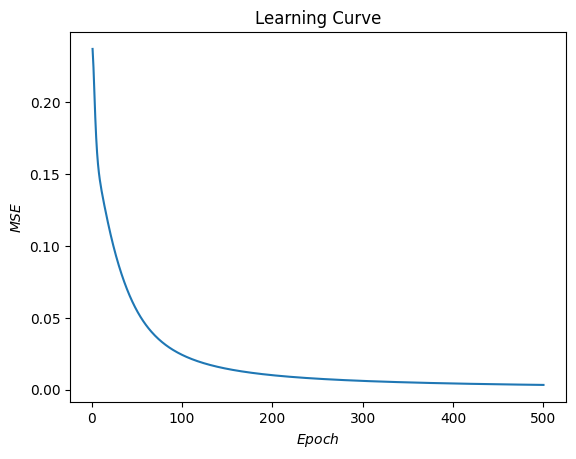

In [ ]:
nodes: int = 100
probablity: float = 1.0e-1
subgraphs: int = 5
labels: list[str] = [0, 1]
colors: list[str] = ['#F2AA84', '#4E95D9']

# パイパーパラメータ
EPOCHS: int = 1000
lr: float = 0.01
momentum: float = 0.9
x_states: int = 10
l_N: int = 1
l_E: int = 0
output_dim: int = 2

# データセットの生成
L, G = create_dataset(nodes, subgraphs, random_state, probablity, labels)

# モデルの設定
model: GNN = GNN(l_N, l_E, x_states, output_dim)
optimizer: Optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
loss_func: nn.Module = nn.MSELoss()

def train() -> None:
    model.train(True)
    loss_list: list[float] = list[float]()
    for _ in range(EPOCHS):
        loss_sum: float = 0.0
        for i in range(subgraphs):
            optimizer.zero_grad()
            y: torch.Tensor = model(L[i]['graph'])
            loss: torch.Tensor = loss_func(L[i]['targets'], y)
            loss_sum += loss.item()
            loss.backward()
            optimizer.step()
        loss_list.append(loss_sum/subgraphs)
    model.train(False)
    plt.plot(range(1, EPOCHS+1), loss_list)
    plt.title('Learning Curve')
    plt.xlabel(r'$Epoch$')
    plt.ylabel(r'$MSE$')
    plt.show()

train()

# Result

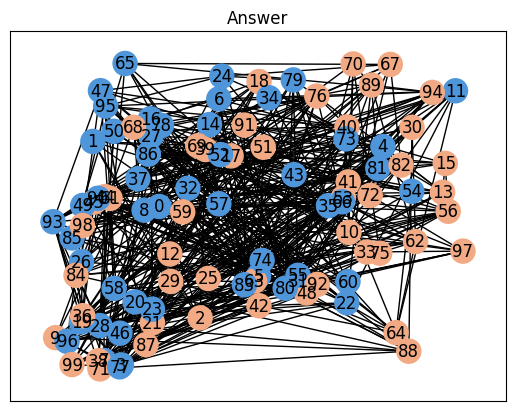

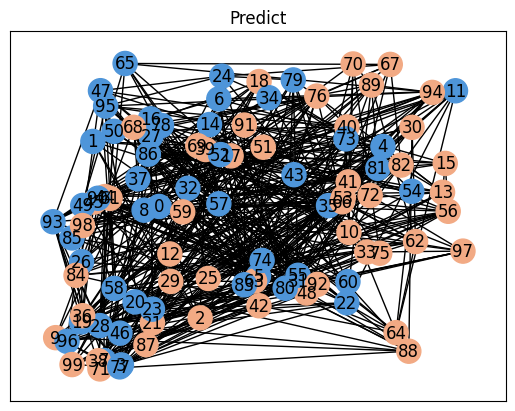

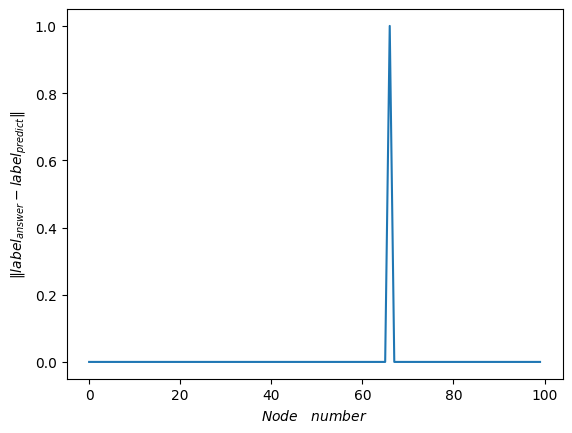

In [647]:
predict_y: torch.Tensor = model(G)
values: dict[str: Any] = dict[str: Any]()
for index, label in enumerate(decode_label(predict_y)):
    values[index] = {
        'label': label
    }
G_predict: Graph = G.copy()
G_predict.update_pos(G.pos)
nx.set_node_attributes(G_predict, values)

G.show(title='Answer', labels=labels, colors=colors)
G_predict.show(title='Predict', labels=labels, colors=colors)
plt.plot([abs(G.node_label(node) - G_predict.node_label(node)) for node in G.nodes])
plt.xlabel(r'$Node \quad number$')
plt.ylabel(r'$\|label_{answer} - label_{predict}\|$')
plt.show()